In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

## gather paired data

In [145]:
# load in the VDJdb data
df = pd.read_table('/ssd1/dchen/GNN_PEPTIDE_TCR/data/vdjdb_confidence2_tratrbpairedonly_hlaa0201_humanonly.tsv')

# check assertions
assert sum(df['Epitope'] == 'NLVPMVATV') == sum(df['Epitope gene'] == 'pp65')
assert df['complex.id'].value_counts().unique() == [2]
assert df['CDR3'].apply(lambda x: x.count(' ')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('_')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('-')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('*')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('#')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('?')).max() == 0

# fix the data types
df['CDR3'], df['Epitope'] = df['CDR3'].str.upper(), df['Epitope'].str.upper()
df = df.loc[~df['CDR3'].apply(lambda x: 'X' in x)]
df = df.loc[~df['Epitope'].apply(lambda x: 'X' in x)]

# gather paired data for everything
df_vdjdb = pd.DataFrame(columns=['CDR3a','CDR3b','Epitope'])
for complex_id in df['complex.id'].unique():
    # gather the data
    tra = df.loc[(df['complex.id'] == complex_id) & (df['Gene'] == 'TRA'), 'CDR3'].iloc[0]
    trb = df.loc[(df['complex.id'] == complex_id) & (df['Gene'] == 'TRB'), 'CDR3'].iloc[0]
    epa = df.loc[(df['complex.id'] == complex_id) & (df['Gene'] == 'TRA'), 'Epitope'].iloc[0]
    epb = df.loc[(df['complex.id'] == complex_id) & (df['Gene'] == 'TRB'), 'Epitope'].iloc[0]
    assert epa == epb
    # add to database
    df_vdjdb.loc[df_vdjdb.shape[0]] = tra, trb, epa

In [146]:
# load in the IEDB data
df = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/iedb.receptor_table_export_1692393367.csv', index_col=0)
df = df.reset_index().iloc[:, 1:]

# filter only for the beta sequences
df = df.loc[(df['Chain 1 - Type'] == 'alpha') & (df['Chain 2 - Type'] == 'beta')]
df = df.dropna(subset=['Chain 1 - CDR3 Curated', 'Chain 2 - CDR3 Curated'])
df = df[['Chain 1 - CDR3 Curated', 'Chain 2 - CDR3 Curated', 'Epitope - Name']]
df.columns = ['CDR3a','CDR3b','Epitope']

# confirm quality
for cdr3 in ['CDR3a','CDR3b']:
    assert df[cdr3].apply(lambda x: x.count(' ')).max() == 0
    assert df[cdr3].apply(lambda x: x.count('_')).max() == 0
    assert df[cdr3].apply(lambda x: x.count('-')).max() == 0

# finalize dataframe
df['CDR3a'], df['CDR3b'], df['Epitope'] = df['CDR3a'].str.upper(), df['CDR3b'].str.upper(), df['Epitope'].str.upper()
for to_remove in ['X','#','*','?']:
    df = df.loc[~df['CDR3a'].apply(lambda x: to_remove in x)]
    df = df.loc[~df['CDR3b'].apply(lambda x: to_remove in x)]
    df = df.loc[~df['Epitope'].apply(lambda x: to_remove in x)]
df_iedb = df.copy()

/tmp/ipykernel_20086/35833481.py:2: DtypeWarning: Columns (2,10,11,12,13,14,15,16,18,19,20,21,22,23,28,29,34,35,42,43,44,45,46,47,48,49,50,57,58,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/iedb.receptor_table_export_1692393367.csv', index_col=0)


In [147]:
# load in the McPAS data
df = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/McPAS-TCR.csv', encoding='windows-1252')
mask = (df['Species'] == 'Human') & (df['MHC'].isin(['HLA-A*02:01','HLA-A*2:01','HLA-A*2:01,*6:801']))
df = df.loc[mask, ['CDR3.alpha.aa','CDR3.beta.aa','Epitope.peptide']].dropna()
df.columns = ['CDR3a','CDR3b','Epitope']

# confirm quality
for cdr3 in ['CDR3a','CDR3b']:
    assert df[cdr3].apply(lambda x: x.count(' ')).max() == 0
    assert df[cdr3].apply(lambda x: x.count('_')).max() == 0
    assert df[cdr3].apply(lambda x: x.count('-')).max() == 0
    assert df[cdr3].apply(lambda x: x.count('*')).max() == 0
    
# finalize dataframe
df['CDR3a'], df['CDR3b'], df['Epitope'] = df['CDR3a'].str.upper(), df['CDR3b'].str.upper(), df['Epitope'].str.upper()
for to_remove in ['X','#','?']:
    df = df.loc[~df['CDR3a'].apply(lambda x: to_remove in x)]
    df = df.loc[~df['CDR3b'].apply(lambda x: to_remove in x)]
    df = df.loc[~df['Epitope'].apply(lambda x: to_remove in x)]
df_mcpas = df.copy()

/tmp/ipykernel_20086/1325798942.py:2: DtypeWarning: Columns (13,17,24,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/McPAS-TCR.csv', encoding='windows-1252')


In [150]:
# combine all of the datasets
df = pd.concat([df_vdjdb, df_iedb, df_mcpas], axis=0)
# remove any erroneous epitopes (triple check)
df = df.loc[df['Epitope'].apply(lambda x: x.count(' ')) == 0]
df = df.loc[df['Epitope'].apply(lambda x: x.count('_')) == 0]
df = df.loc[df['Epitope'].apply(lambda x: x.count('-')) == 0]
df = df.loc[df['Epitope'].apply(lambda x: x.count('*')) == 0]
df = df.loc[df['Epitope'].apply(lambda x: x.count('#')) == 0]
df = df.loc[df['Epitope'].apply(lambda x: x.count('X')) == 0]
df = df.loc[df['Epitope'].apply(lambda x: x.count('?')) == 0]

## quality control of TCR-Ag pairs

[Text(0.5, 0, 'Length'), Text(0, 0.5, 'N-CDR3s')]

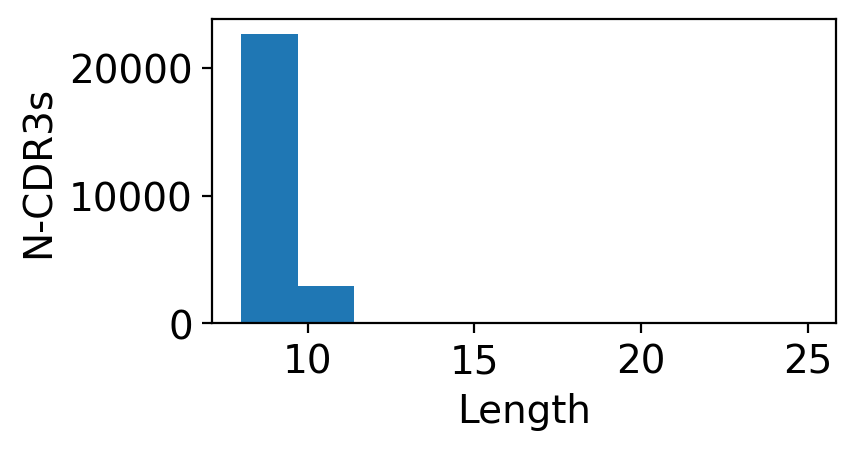

In [151]:
# examine lengths of peptides
fig, ax = plt.subplots(figsize=[4, 2])
ax.grid(False)
ax.hist(df['Epitope'].apply(len), bins=10)
ax.set(xlabel='Length', ylabel='N-CDR3s')

In [152]:
# accepted range of epitopes falls between 8-11
df = df.loc[(df['Epitope'].apply(len) <= 11) & (df['Epitope'].apply(len) >= 8)]

[Text(0.5, 0, 'Length'), Text(0, 0.5, 'N-Peptides')]

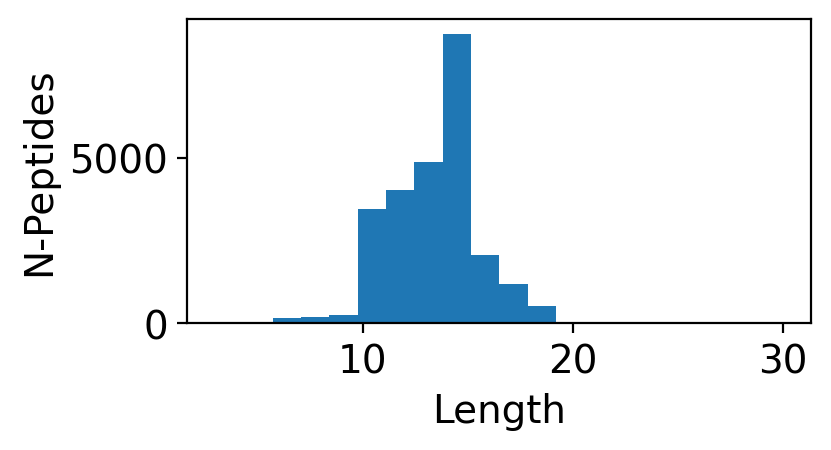

In [153]:
# examine lengths of cdr3as
fig, ax = plt.subplots(figsize=[4, 2])
ax.grid(False)
ax.hist(df['CDR3a'].apply(len), bins=20)
ax.set(xlabel='Length', ylabel='N-Peptides')

[Text(0.5, 0, 'Length'), Text(0, 0.5, 'N-Peptides')]

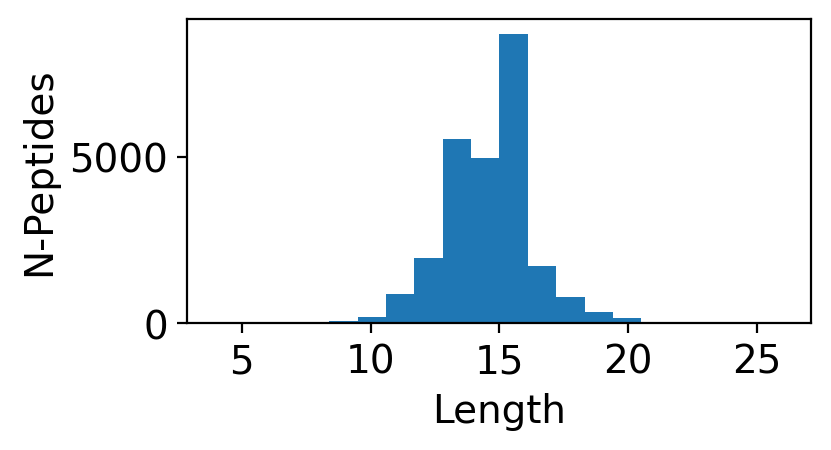

In [154]:
# examine lengths of cdr3bs
fig, ax = plt.subplots(figsize=[4, 2])
ax.grid(False)
ax.hist(df['CDR3b'].apply(len), bins=20)
ax.set(xlabel='Length', ylabel='N-Peptides')

In [155]:
# accepted range of cdr3s falls between 10-22 for b and 9-21 for a
df = df.loc[(df['CDR3a'].apply(len) <= 21) & (df['CDR3a'].apply(len) >= 9)]
df = df.loc[(df['CDR3b'].apply(len) <= 22) & (df['CDR3b'].apply(len) >= 10)]
df = df.reset_index().iloc[:, 1:]

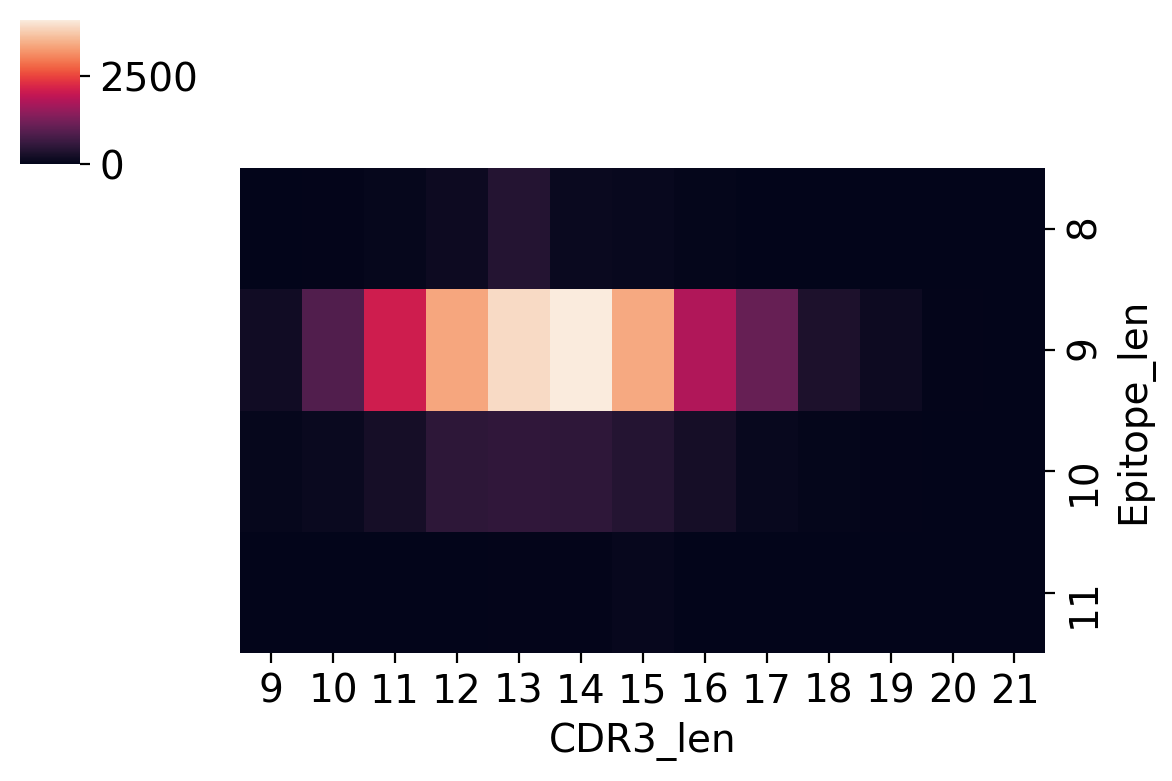

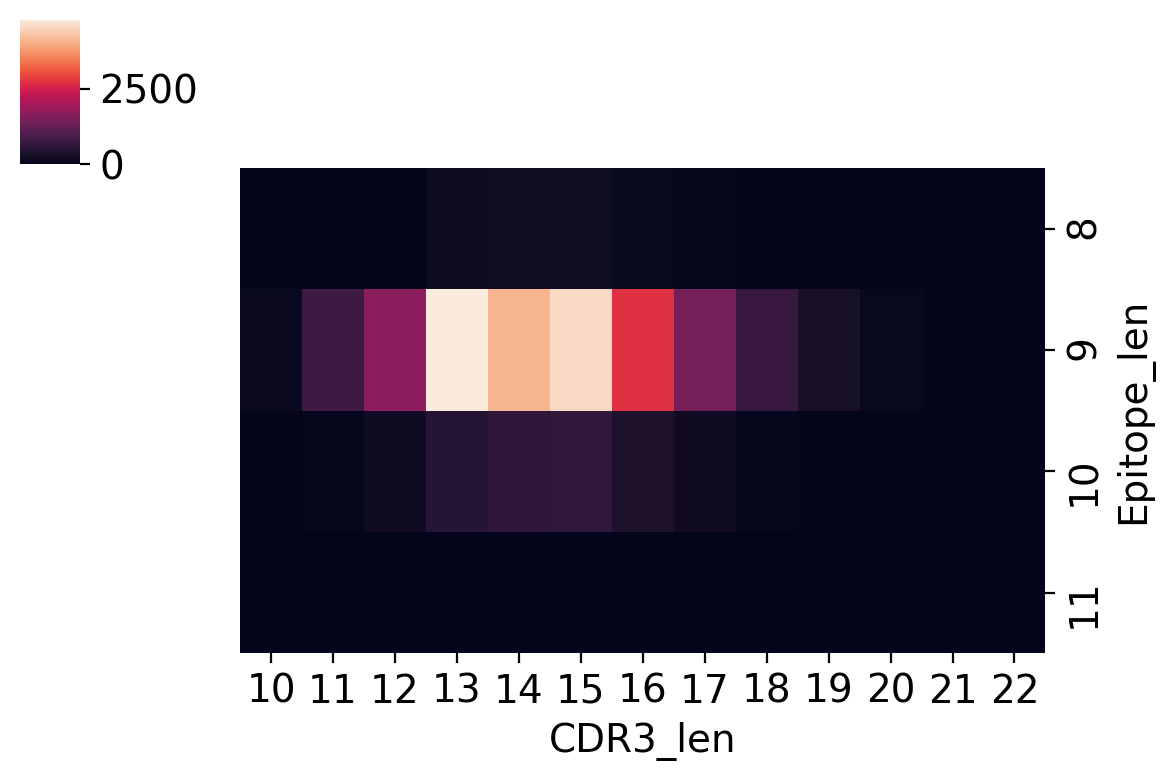

In [156]:
# examine lengths
for cdr3 in ['CDR3a','CDR3b']:
    df['CDR3_len'], df['Epitope_len'] = df[cdr3].apply(len), df['Epitope'].apply(len)

    plot = df[['CDR3_len','Epitope_len']].value_counts().reset_index()
    plot = plot.pivot_table(index='Epitope_len', columns='CDR3_len', values='count', aggfunc=np.sum)

    g = sns.clustermap(plot.astype(float).fillna(0), figsize=[6, 4],
                       row_cluster=False, col_cluster=False)

## clean and process TCR-Ag data; prepare Levenshtein matrix

In [157]:
# now we need to mix and match to ensure we get good representation of negative samples as well
df = df[['CDR3a','CDR3b','Epitope']]
counts = df['Epitope'].value_counts()
counts.iloc[:5]

Epitope
KLGGALQAK     11374
GILGFVFTL      2048
AVFDRKSDAK     1352
RAKFKQLL        796
NLVPMVATV       686
Name: count, dtype: int64

In [158]:
from Levenshtein import distance
from tqdm import tqdm
# our goal here is to find the similar and different peptides in our dataset
df_l = pd.DataFrame(index=counts.index, columns=counts.index)
for idx, pep1 in tqdm(enumerate(counts.index[:-1]), total=df_l.shape[0]):
    df_l.loc[pep1, pep1] = 0
    for pep2 in counts.index[idx+1:]:
        d = distance(pep1, pep2)
        df_l.loc[pep1, pep2] = d
        df_l.loc[pep2, pep1] = d
df_l.loc[pep2, pep2] = 0

# write down this table
!mkdir ../outputs/model_v6/
df_l.to_csv('../outputs/model_v6/full.epitope.levenshtein.csv')

100%|██████████████████████████████████████▉| 1229/1230 [01:17<00:00, 15.82it/s]


mkdir: cannot create directory ‘../outputs/model_v6/’: File exists


/tmp/ipykernel_20086/623145791.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(df_l.astype(float), method='ward')


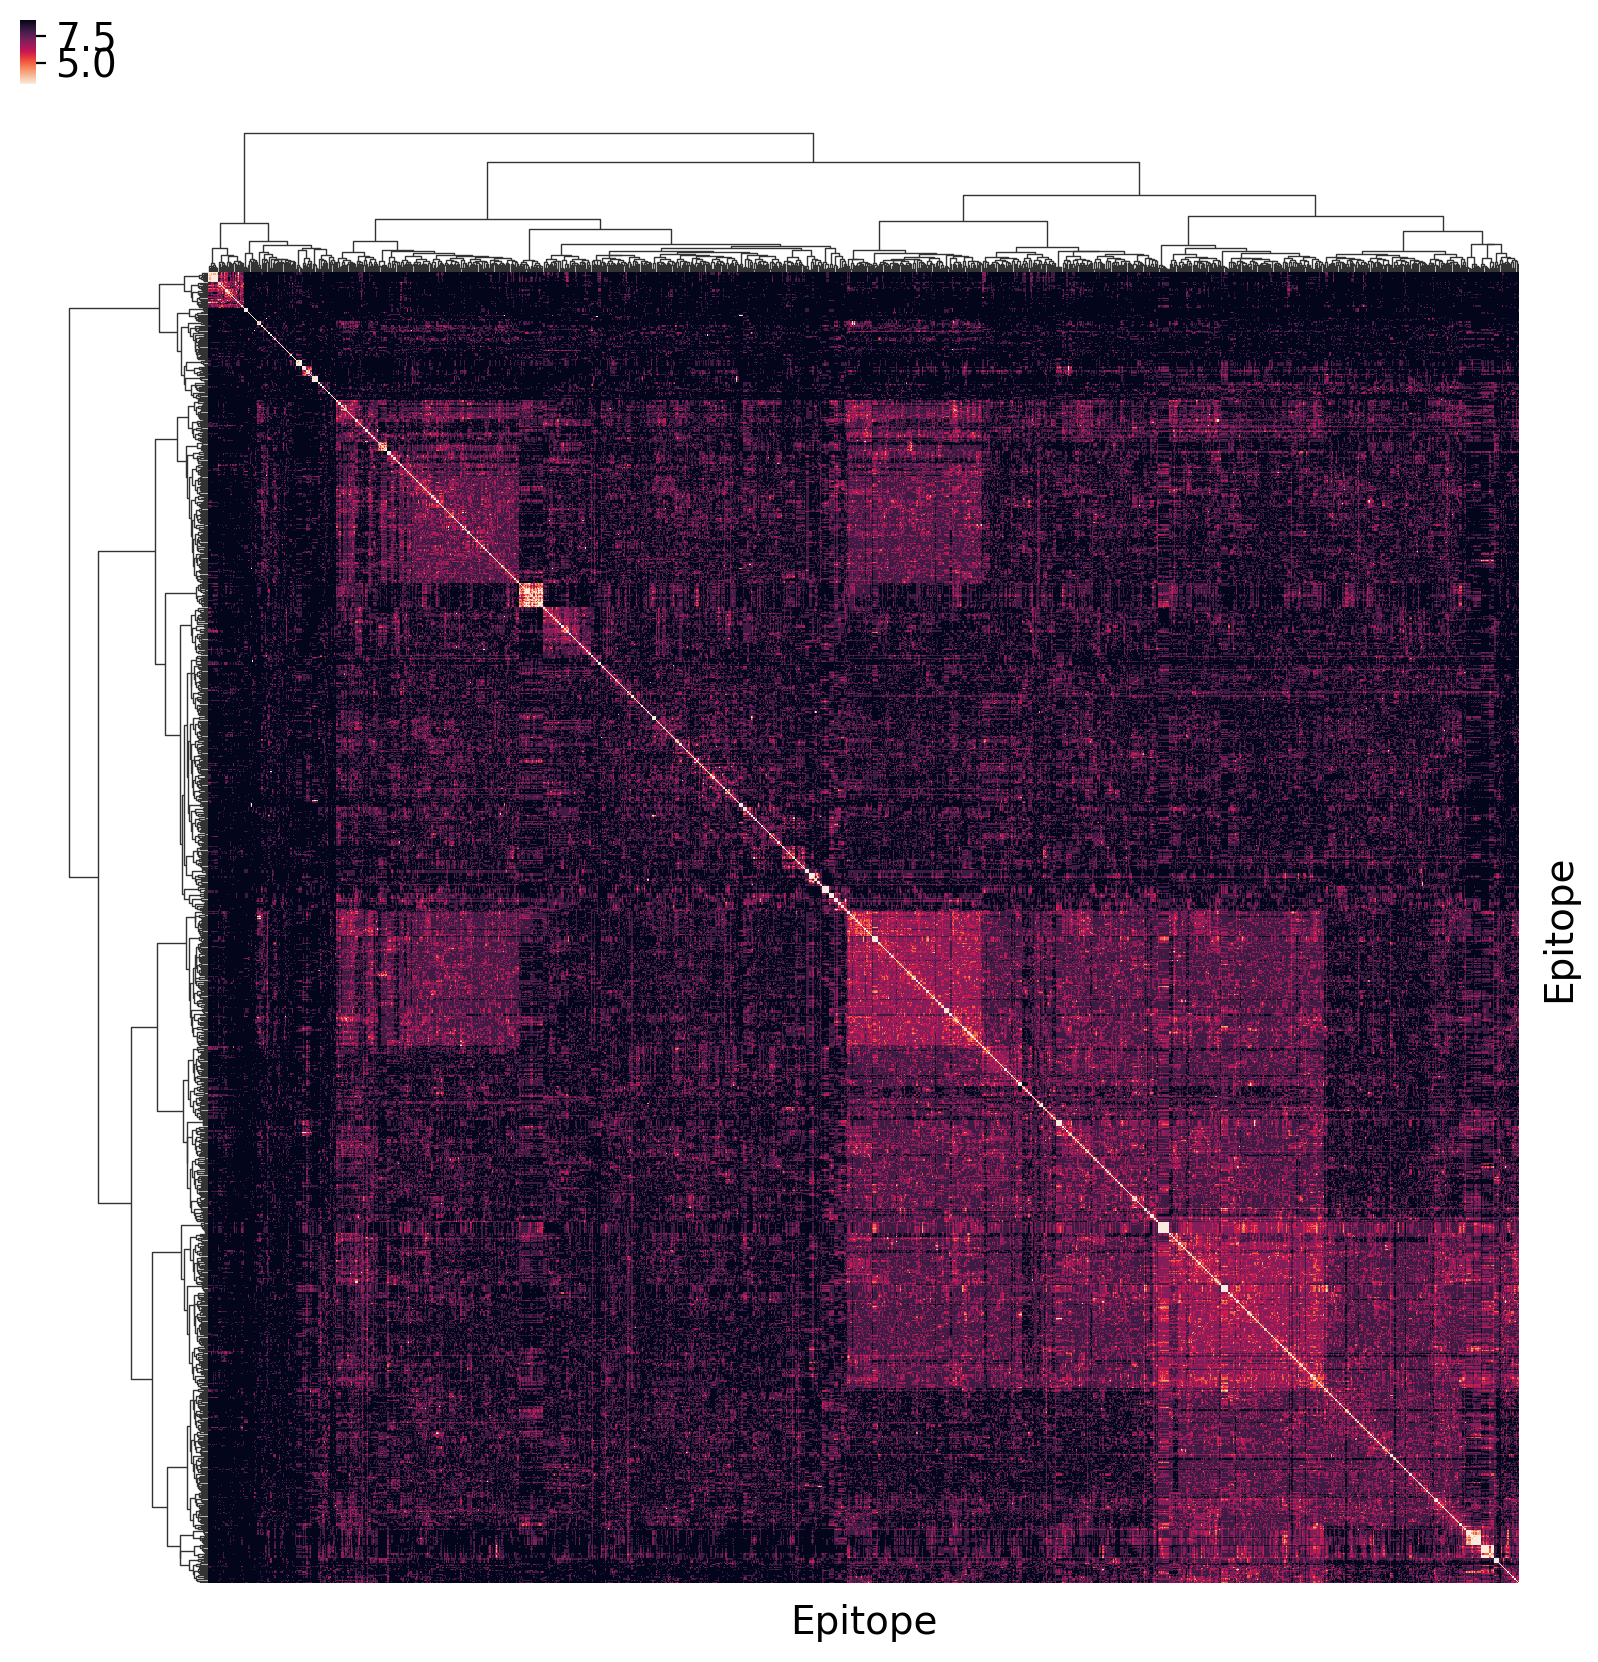

In [159]:
# gather linkage and fcluster
from scipy.cluster.hierarchy import linkage
# get dendrogram information
Z = linkage(df_l.astype(float), method='ward')
# plot levenshtein
sns.clustermap(df_l.astype(float), figsize=[8, 8], method='ward', xticklabels=0, yticklabels=0,
               dendrogram_ratio=.1, cbar_pos=(0, 1, .01, .04),
               vmin=3, vmax=9, cmap='rocket_r', row_linkage=Z, col_linkage=Z)

In [160]:
# save the hits for future use
df.to_csv('../outputs/model_v6/full.input.X.csv')

## retrieve negative controls

In [161]:
from tqdm import tqdm
# set seed and identify irrelevant matches
np.random.seed(0)
irrs = []

for pep in tqdm(df_l.index):
    # gather peptide cdr3 information
    n_cdr3s = counts.loc[pep]
    pep_cdr3s = df.loc[df['Epitope'] == pep, ['CDR3a','CDR3b']]
    # we first grab the peptide levenshtein distances
    pep_levenshtein = df_l[pep].sort_values()[::-1]
    # systematically identify negative controls
    irr_cdr3s = []
    while n_cdr3s > 0:
        # then we look at the max distance, gather those peptides, randomly choose one
        # find associated CDR3s that don't overlap with the current peptide
        vmax = pep_levenshtein.max()
        irr_peps = pep_levenshtein.index[pep_levenshtein == vmax]
        # reset for the next round if needed
        pep_levenshtein = pep_levenshtein[pep_levenshtein < vmax]
        # find the irrelevant peptide CDR3s and make sure they don't overlap
        mask = (df['Epitope'].isin(irr_peps)) & \
        ((~df['CDR3a'].isin(pep_cdr3s['CDR3a'])) | (~df['CDR3b'].isin(pep_cdr3s['CDR3b'])))
        if sum(mask) == 0:
            continue
        # if we have cdr3s then grab them out
        cdr3s = df.loc[mask, ['CDR3a','CDR3b']]
        # if there are more than we need randomly select
        if len(cdr3s) > n_cdr3s:
            irr_idxs = np.random.choice(cdr3s.index, size=n_cdr3s, replace=False)
            irr_cdr3s += cdr3s.loc[irr_idxs].values.tolist()
            break
        # otherwise keep moving
        else:
            irr_cdr3s += cdr3s.values.tolist()
            n_cdr3s -= len(cdr3s)
    # compile the full list
    irr = pd.DataFrame(irr_cdr3s, columns=['CDR3a','CDR3b'])
    irr['Epitope'] = pep
    irrs.append(irr)

100%|███████████████████████████████████████| 1230/1230 [00:13<00:00, 93.18it/s]


In [162]:
# gather irrelevant pairs
irr = pd.concat(irrs, axis=0)
# write the control input
irr.to_csv('../outputs/model_v6/full.control.X.csv')

## confirm that positive and negative controls are of differing sequences

In [163]:
import scipy.stats as ss
from Levenshtein import distance
from tqdm import tqdm

# check all epitopes
epitopes = df['Epitope'].unique()
# create tracking dataframe for the values
df_stat = pd.DataFrame(columns=['posxpos','posxneg','negxneg'], index=epitopes)
# fill in statistics
for epitope in tqdm(df_stat.index):
    # try this a few times to get a good estimation
    posxposs, posxnegs, negxnegs = [], [], []

    # monte carlo simulation this
    for seed in range(10):
        # set the random seed
        np.random.seed(seed)

        # compare the average levenshtein distance
        pos_cdr3s = np.random.choice(df.loc[df['Epitope'] == epitope, 'CDR3a'], size=100, replace=True)
        neg_cdr3s = np.random.choice(irr.loc[irr['Epitope'] == epitope, 'CDR3a'], size=100, replace=True)

        # compute distances
        posxpos = []
        for idx, pep1 in enumerate(pos_cdr3s[:-1]):
            for pep2 in pos_cdr3s[idx+1:]:
                posxpos.append(distance(pep1, pep2))
        posxpos = np.mean(posxpos)

        posxneg = []
        for pep1 in pos_cdr3s:
            for pep2 in neg_cdr3s:
                posxneg.append(distance(pep1, pep2))
        posxneg = np.mean(posxneg)

        negxneg = []
        for idx, pep1 in enumerate(neg_cdr3s[:-1]):
            for pep2 in neg_cdr3s[idx+1:]:
                negxneg.append(distance(pep1, pep2))
        negxneg = np.mean(negxneg)

        # save the values
        posxposs.append(posxpos)
        posxnegs.append(posxneg)
        negxnegs.append(negxneg)
        
    # now add to dataframe
    df_stat.loc[epitope] = np.mean(posxposs), np.mean(posxnegs), np.mean(negxnegs)

100%|███████████████████████████████████████| 1230/1230 [02:56<00:00,  6.97it/s]


/tmp/ipykernel_20086/740240423.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,
/tmp/ipykernel_20086/740240423.py:7: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,
/tmp/ipykernel_20086/740240423.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,


0.0
0.0
0.2944168868773821


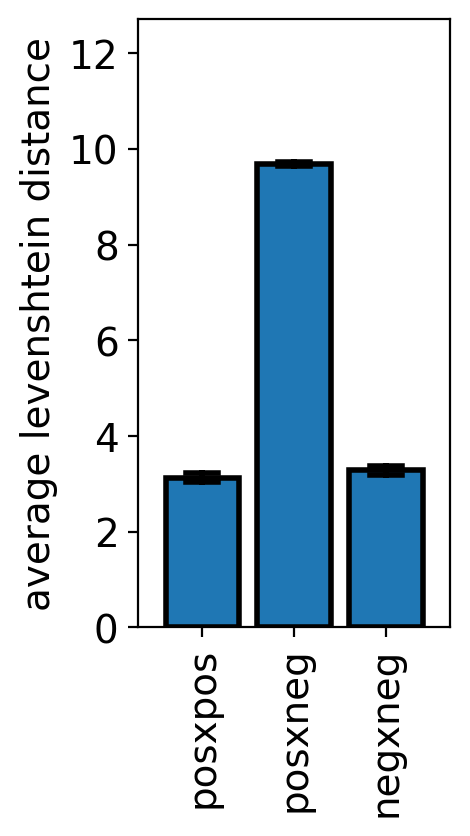

In [164]:
# grab the data
plot = df_stat.melt()

# setup the barplots
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,
            saturation=1, edgecolor='k', linewidth=2, errcolor='k')
ax.tick_params(axis='x', labelrotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin-0.2, xmax+0.2)
ax.set_xlabel('')
ax.set_ylabel('average levenshtein distance')
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax + 2.5)

print(ss.mannwhitneyu(plot['value'][plot['variable'] == 'posxpos'].astype(float),
                   plot['value'][plot['variable'] == 'posxneg'].astype(float))[1])
print(ss.mannwhitneyu(plot['value'][plot['variable'] == 'negxneg'].astype(float),
                   plot['value'][plot['variable'] == 'posxneg'].astype(float))[1])
print(ss.mannwhitneyu(plot['value'][plot['variable'] == 'posxpos'].astype(float),
                   plot['value'][plot['variable'] == 'negxneg'].astype(float))[1])

In [165]:
# check for normality
print(ss.normaltest(plot['value'].astype(float)))

NormaltestResult(statistic=24431.92989926529, pvalue=0.0)


In [166]:
# repeat for CDR3b

# check all epitopes
epitopes = df['Epitope'].unique()
# create tracking dataframe for the values
df_stat = pd.DataFrame(columns=['posxpos','posxneg','negxneg'], index=epitopes)
# fill in statistics
for epitope in tqdm(df_stat.index):
    # try this a few times to get a good estimation
    posxposs, posxnegs, negxnegs = [], [], []

    # monte carlo simulation this
    for seed in range(10):
        # set the random seed
        np.random.seed(seed)

        # compare the average levenshtein distance
        pos_cdr3s = np.random.choice(df.loc[df['Epitope'] == epitope, 'CDR3b'], size=100, replace=True)
        neg_cdr3s = np.random.choice(irr.loc[irr['Epitope'] == epitope, 'CDR3b'], size=100, replace=True)

        # compute distances
        posxpos = []
        for idx, pep1 in enumerate(pos_cdr3s[:-1]):
            for pep2 in pos_cdr3s[idx+1:]:
                posxpos.append(distance(pep1, pep2))
        posxpos = np.mean(posxpos)

        posxneg = []
        for pep1 in pos_cdr3s:
            for pep2 in neg_cdr3s:
                posxneg.append(distance(pep1, pep2))
        posxneg = np.mean(posxneg)

        negxneg = []
        for idx, pep1 in enumerate(neg_cdr3s[:-1]):
            for pep2 in neg_cdr3s[idx+1:]:
                negxneg.append(distance(pep1, pep2))
        negxneg = np.mean(negxneg)

        # save the values
        posxposs.append(posxpos)
        posxnegs.append(posxneg)
        negxnegs.append(negxneg)
        
    # now add to dataframe
    df_stat.loc[epitope] = np.mean(posxposs), np.mean(posxnegs), np.mean(negxnegs)

100%|███████████████████████████████████████| 1230/1230 [02:55<00:00,  7.00it/s]


/tmp/ipykernel_20086/740240423.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,
/tmp/ipykernel_20086/740240423.py:7: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,
/tmp/ipykernel_20086/740240423.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,


0.0
1.5187774750235552e-303
0.011477697651611607


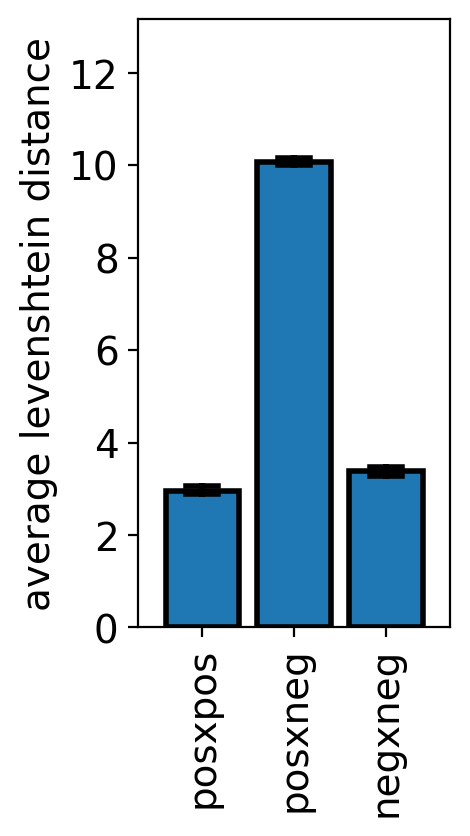

In [167]:
# grab the data
plot = df_stat.melt()

# setup the barplots
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,
            saturation=1, edgecolor='k', linewidth=2, errcolor='k')
ax.tick_params(axis='x', labelrotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin-0.2, xmax+0.2)
ax.set_xlabel('')
ax.set_ylabel('average levenshtein distance')
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax + 2.5)

print(ss.mannwhitneyu(plot['value'][plot['variable'] == 'posxpos'].astype(float),
                   plot['value'][plot['variable'] == 'posxneg'].astype(float))[1])
print(ss.mannwhitneyu(plot['value'][plot['variable'] == 'negxneg'].astype(float),
                   plot['value'][plot['variable'] == 'posxneg'].astype(float))[1])
print(ss.mannwhitneyu(plot['value'][plot['variable'] == 'posxpos'].astype(float),
                   plot['value'][plot['variable'] == 'negxneg'].astype(float))[1])

In [168]:
# check for normality
print(ss.normaltest(plot['value'].astype(float)))

NormaltestResult(statistic=1793.7593877308636, pvalue=0.0)


## prepare dual chain model

In [2]:
import tensorflow as tf
from tensorflow import keras

%load_ext tensorboard

2024-01-11 00:26:22.991996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 00:26:23.165903: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 00:26:23.787157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-11 00:26:23.787256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [5]:
from constants import *
import multiprocessing as mp

## DEFINE CONSTANTS
stretch_length_cdr3 = 30
stretch_length_ag = 15
aa_alphabet = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
bcps = ['charge','hydrophobicity','weight','sulfur','aromatic']

## DEFINE ENCODERS
def _encode_peptide(peptide):
    # define columns
    idxs = range(len(peptide))
    cols = aa_alphabet+bcps
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=idxs, columns=cols)
    for idx, aa in enumerate(peptide):
        # map to each of the bio-chem-physical components
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / stretch_length_cdr3
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        # store in the final dataframe
        X.loc[idx, aa_alphabet] = 0
        X.loc[idx, aa] = 1
        X.loc[idx, bcps] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    # now interpolate to the correct length
    X2 = pd.DataFrame(index=range(STRETCH_LENGTH), columns=X.columns)
    for col in X2.columns:
        X2[col] = np.interp(range(STRETCH_LENGTH), range(X.shape[0]), X[col])
    return {peptide:X2}
def encode_peptide(peptides, n_cpus):
    # work through peptides
    peptide_to_X = {}
    with mp.Pool(n_cpus) as pool:
        for result in pool.imap_unordered(_encode_peptide, peptides):
            peptide_to_X.update(result)
    return peptide_to_X

# retrieve encodings
STRETCH_LENGTH = stretch_length_cdr3
cdr3a_to_X2 = encode_peptide(pd.concat([hit, irr], axis=0)['CDR3a'].dropna().unique(), 40)
cdr3b_to_X2 = encode_peptide(pd.concat([hit, irr], axis=0)['CDR3b'].dropna().unique(), 40)
STRETCH_LENGTH = stretch_length_ag
ag_to_X2 = encode_peptide(pd.concat([hit, irr], axis=0)['Epitope'].dropna().unique(), 40)

In [290]:
# separate out the hits and irrs into training and validation
hit = pd.read_csv('../outputs/model_v6/full.input.X.csv', index_col=0).reset_index().iloc[:, 1:]
irr = pd.read_csv('../outputs/model_v6/full.control.X.csv', index_col=0).reset_index().iloc[:, 1:]
print(hit.shape[0], irr.shape[0])
# grab a subset, because hit and irr are the same size now, we just use half of hit size
np.random.seed(0)
n_rows = hit.shape[0] // 2
perc_train = 0.75
# > subset target
idxs = np.random.choice(hit.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
# > subset control
idxs = np.random.choice(irr.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
irr_train, irr_test = irr.loc[idxs], irr.loc[idys]
# confirm no overlap
assert not hit_train.index.isin(hit_test.index).all()
assert not irr_train.index.isin(irr_test.index).all()

25041 25041
9390 3130
9390 3130


In [291]:
# write these files for reviewer access
hit_train.to_csv('../outputs/model_v6/train.pos.csv')
irr_train.to_csv('../outputs/model_v6/train.neg.csv')
hit_test.to_csv('../outputs/model_v6/mid_train_test.pos.csv')
irr_test.to_csv('../outputs/model_v6/mid_train_test.neg.csv')

In [292]:
# > subset target
val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
print(len(val_idxs))
hit_val = hit.loc[val_idxs]
# > subset control
val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
print(len(val_idxs))
irr_val = irr.loc[val_idxs]

12521
12521


In [293]:
# write these files for reviewer access
hit_val.to_csv('../outputs/model_v6/validation.pos.csv')
irr_val.to_csv('../outputs/model_v6/validation.neg.csv')

In [78]:
## CONVERT TO CORRECT FORMAT
def convert_to_X(hit, irr):
    # create X for training
    X = pd.concat([hit, irr], axis=0).reset_index().iloc[:, 1:]
    X_cdr3as = np.array([cdr3a_to_X2[x] for x in X['CDR3a']])
    X_cdr3bs = np.array([cdr3b_to_X2[x] for x in X['CDR3b']])
    X_ags = np.array([ag_to_X2[x] for x in X['Epitope']])
    # grab y for training
    y = pd.Series([1]*hit.shape[0]+[0]*irr.shape[0], index=X.index)
    # confirm the same length
    assert X.shape[0] == y.shape[0]
    return X_cdr3as, X_cdr3bs, X_ags, y

# convert training
print('converting training data...')
X_cdr3as_train, X_cdr3bs_train, X_ags_train, y_train = convert_to_X(hit_train, irr_train)

# convert testing
print('converting testing data...')
X_cdr3as_test, X_cdr3bs_test, X_ags_test, y_test = convert_to_X(hit_test, irr_test)

# convert validation
print('converting validation data...')
X_cdr3as_val, X_cdr3bs_val, X_ags_val, y_val = convert_to_X(hit_val, irr_val)

converting training data...
converting testing data...
converting validation data...


In [79]:
## SETUP MODEL
def get_model():
    # > layer for tra
    input_1 = keras.layers.Input(shape=(stretch_length_cdr3, len(aa_alphabet)+len(bcps)))
    output_1 = keras.layers.Conv1D(30, 3, activation='gelu')(input_1)
    flatten_1a = keras.layers.Flatten()(output_1)
    flatten_1b = keras.layers.Flatten()(input_1)
    concat_1 = keras.layers.Concatenate()([flatten_1a, flatten_1b])
    dropout_1 = keras.layers.Dropout(rate=0.10)(concat_1)
    output_1 = keras.layers.Dense(300, activation='sigmoid')(dropout_1)
    # > layer for trb
    input_2 = keras.layers.Input(shape=(stretch_length_cdr3, len(aa_alphabet)+len(bcps)))
    output_2 = keras.layers.Conv1D(30, 3, activation='gelu')(input_2)
    flatten_2a = keras.layers.Flatten()(output_2)
    flatten_2b = keras.layers.Flatten()(input_2)
    concat_2 = keras.layers.Concatenate()([flatten_2a, flatten_2b])
    dropout_2 = keras.layers.Dropout(rate=0.10)(concat_2)
    output_2 = keras.layers.Dense(300, activation='sigmoid')(dropout_2)
    # > layer for ag
    input_3 = keras.layers.Input(shape=(stretch_length_ag, len(aa_alphabet)+len(bcps)))
    output_3 = keras.layers.Conv1D(15, 3, activation='gelu')(input_2)
    flatten_3a = keras.layers.Flatten()(output_3)
    flatten_3b = keras.layers.Flatten()(input_3)
    concat_3 = keras.layers.Concatenate()([flatten_3a, flatten_3b])
    dropout_3 = keras.layers.Dropout(rate=0.10)(concat_3)
    output_3 = keras.layers.Dense(150, activation='sigmoid')(dropout_3)
    # > concat tra + ag
    concat_13 = keras.layers.Concatenate()([output_1, output_3])
    dropout_13 = keras.layers.Dropout(rate=0.10)(concat_13)
    output_13 = keras.layers.Dense(100, activation='sigmoid')(dropout_13)
    # > concat trb + ag
    concat_23 = keras.layers.Concatenate()([output_2, output_3])
    dropout_23 = keras.layers.Dropout(rate=0.10)(concat_23)
    output_23 = keras.layers.Dense(100, activation='sigmoid')(dropout_23)
    # > concat tra + trb
    concat_12 = keras.layers.Concatenate()([output_1, output_2])
    dropout_12 = keras.layers.Dropout(rate=0.10)(concat_12)
    output_12 = keras.layers.Dense(100, activation='sigmoid')(dropout_12)
    # > concat tra+trb + ag
    concat_123 = keras.layers.Concatenate()([output_12, output_3])
    dropout_123 = keras.layers.Dropout(rate=0.10)(concat_123)
    output_123 = keras.layers.Dense(100, activation='sigmoid')(dropout_123)
    # > full combination
    concat_full = keras.layers.Concatenate()([output_12, output_13, output_123])
    dropout_full = keras.layers.Dropout(rate=0.10)(concat_full)
    output_full = keras.layers.Dense(1, activation='sigmoid')(dropout_full)
    model = keras.Model(inputs=[input_1, input_2, input_3], outputs=[output_full])

    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    return model

# train the model
model = get_model()
history = model.fit([X_cdr3as_train, X_cdr3bs_train, X_ags_train], y_train,
                    epochs=20,
                    validation_data=([X_cdr3as_test, X_cdr3bs_test, X_ags_test], y_test),
                    workers=40, use_multiprocessing=True)

Epoch 1/20
587/587 [==============================] - 7s 11ms/step - loss: 0.6878 - accuracy: 0.5274 - auc: 0.5442 - val_loss: 0.6783 - val_accuracy: 0.5006 - val_auc: 0.5964
Epoch 2/20
587/587 [==============================] - 6s 10ms/step - loss: 0.6625 - accuracy: 0.5645 - auc: 0.5986 - val_loss: 0.6500 - val_accuracy: 0.5896 - val_auc: 0.6656
Epoch 3/20
587/587 [==============================] - 6s 10ms/step - loss: 0.6205 - accuracy: 0.6161 - auc: 0.6741 - val_loss: 0.6095 - val_accuracy: 0.6211 - val_auc: 0.6908
Epoch 4/20
587/587 [==============================] - 6s 10ms/step - loss: 0.5965 - accuracy: 0.6455 - auc: 0.7125 - val_loss: 0.5959 - val_accuracy: 0.6458 - val_auc: 0.7146
Epoch 5/20
587/587 [==============================] - 6s 10ms/step - loss: 0.5800 - accuracy: 0.6576 - auc: 0.7341 - val_loss: 0.5834 - val_accuracy: 0.6521 - val_auc: 0.7292
Epoch 6/20
587/587 [==============================] - 6s 10ms/step - loss: 0.5599 - accuracy: 0.6792 - auc: 0.7609 - val_loss

In [80]:
# testing predictions
y_pred = model.predict([X_cdr3as_val, X_cdr3bs_val, X_ags_val],
                       workers=40, use_multiprocessing=True)[:, 0]
y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')

783/783 [==============================] - 3s 3ms/step


Validation AUC 0.8134181009894272


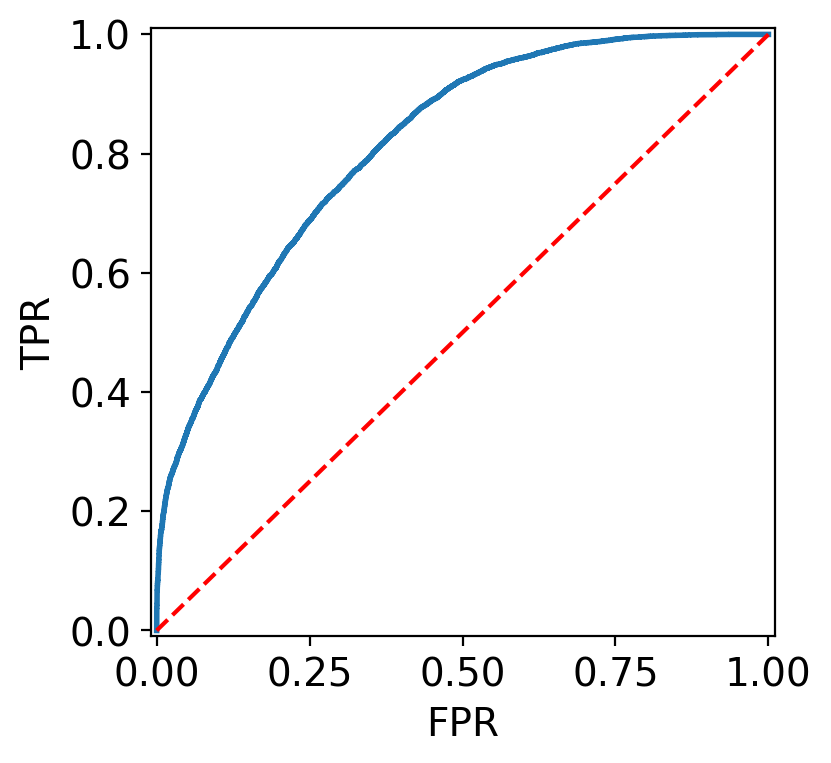

In [81]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# do a very simple check on accuracy
y_pred = pd.concat([y_pred, y_val], axis=1)
fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
# check the AUC
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.grid(False)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
print('Validation AUC', auc(fpr, tpr))

In [82]:
# save the model
model.save('../outputs/model_v6/model_v6.r1.keras')

## cross-validate dual-chain model

In [162]:
# we'll read both of these values and the original input and irrelevant tcrs
hit = pd.read_csv('../outputs/model_v6/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v6/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

# complete 10 iterations
for seed in range(10):
    ## SETUP CONSTANTS
    # grab a subset
    np.random.seed(seed)
    n_rows = hit.shape[0] // 2
    perc_train = 0.75

    ## SEPARATE OUT TRAINING AND TESTING
    # grab a subset, because hit and irr are the same size now, we just use half of hit size
    np.random.seed(0)
    n_rows = hit.shape[0] // 2
    perc_train = 0.75
    # > subset target
    idxs = np.random.choice(hit.index, size=n_rows, replace=False)
    idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
    print(len(idxs), len(idys))
    hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
    # > subset control
    idxs = np.random.choice(irr.index, size=n_rows, replace=False)
    idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
    print(len(idxs), len(idys))
    irr_train, irr_test = irr.loc[idxs], irr.loc[idys]
    # confirm no overlap
    assert not hit_train.index.isin(hit_test.index).all()
    assert not irr_train.index.isin(irr_test.index).all()

    # > subset target
    val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
    print(len(val_idxs))
    hit_val = hit.loc[val_idxs]
    # > subset control
    val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
    print(len(val_idxs))
    irr_val = irr.loc[val_idxs]
    
    ## CONVERT TO CORRECT FORMAT
    X_cdr3as_train, X_cdr3bs_train, X_ags_train, y_train = convert_to_X(hit_train, irr_train)
    X_cdr3as_test, X_cdr3bs_test, X_ags_test, y_test = convert_to_X(hit_test, irr_test)
    X_cdr3as_val, X_cdr3bs_val, X_ags_val, y_val = convert_to_X(hit_val, irr_val)

    ## TRAIN THE MODEL
    model = get_model()
    history = model.fit([X_cdr3as_train, X_cdr3bs_train, X_ags_train], y_train,
                        epochs=20,
                        validation_data=([X_cdr3as_test, X_cdr3bs_test, X_ags_test], y_test),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_cdr3as_val, X_cdr3bs_val, X_ags_val],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))

9390 3130
9390 3130
12521
12521
Epoch 1/20
587/587 [==============================] - 7s 10ms/step - loss: 0.6903 - accuracy: 0.5212 - auc: 0.5326 - val_loss: 0.6769 - val_accuracy: 0.5315 - val_auc: 0.5861
Epoch 2/20
587/587 [==============================] - 6s 10ms/step - loss: 0.6657 - accuracy: 0.5625 - auc: 0.5922 - val_loss: 0.6393 - val_accuracy: 0.5981 - val_auc: 0.6593
Epoch 3/20
587/587 [==============================] - 6s 9ms/step - loss: 0.6263 - accuracy: 0.6121 - auc: 0.6692 - val_loss: 0.6131 - val_accuracy: 0.6203 - val_auc: 0.6899
Epoch 4/20
587/587 [==============================] - 6s 10ms/step - loss: 0.6012 - accuracy: 0.6453 - auc: 0.7104 - val_loss: 0.5940 - val_accuracy: 0.6503 - val_auc: 0.7209
Epoch 5/20
587/587 [==============================] - 6s 9ms/step - loss: 0.5817 - accuracy: 0.6584 - auc: 0.7333 - val_loss: 0.5806 - val_accuracy: 0.6637 - val_auc: 0.7338
Epoch 6/20
587/587 [==============================] - 6s 10ms/step - loss: 0.5638 - accuracy: 0

Epoch 12/20
587/587 [==============================] - 6s 9ms/step - loss: 0.4292 - accuracy: 0.7774 - auc: 0.8739 - val_loss: 0.5390 - val_accuracy: 0.7256 - val_auc: 0.8094
Epoch 13/20
587/587 [==============================] - 6s 9ms/step - loss: 0.4112 - accuracy: 0.7878 - auc: 0.8853 - val_loss: 0.5371 - val_accuracy: 0.7204 - val_auc: 0.8116
Epoch 14/20
587/587 [==============================] - 6s 9ms/step - loss: 0.3984 - accuracy: 0.7968 - auc: 0.8924 - val_loss: 0.5424 - val_accuracy: 0.7292 - val_auc: 0.8160
Epoch 15/20
587/587 [==============================] - 6s 10ms/step - loss: 0.3767 - accuracy: 0.8118 - auc: 0.9056 - val_loss: 0.5573 - val_accuracy: 0.7235 - val_auc: 0.8148
Epoch 16/20
587/587 [==============================] - 6s 10ms/step - loss: 0.3578 - accuracy: 0.8220 - auc: 0.9155 - val_loss: 0.5743 - val_accuracy: 0.7216 - val_auc: 0.8165
Epoch 17/20
587/587 [==============================] - 6s 9ms/step - loss: 0.3472 - accuracy: 0.8305 - auc: 0.9210 - val_lo

Epoch 18/20
587/587 [==============================] - 6s 9ms/step - loss: 0.3314 - accuracy: 0.8403 - auc: 0.9288 - val_loss: 0.5549 - val_accuracy: 0.7319 - val_auc: 0.8242
Epoch 19/20
587/587 [==============================] - 6s 9ms/step - loss: 0.3139 - accuracy: 0.8513 - auc: 0.9366 - val_loss: 0.5877 - val_accuracy: 0.7288 - val_auc: 0.8216
Epoch 20/20
783/783 [==============================] - 3s 4ms/step
9390 3130
9390 3130
12521
12521
Epoch 1/20
587/587 [==============================] - 7s 10ms/step - loss: 0.6853 - accuracy: 0.5306 - auc: 0.5471 - val_loss: 0.6697 - val_accuracy: 0.5625 - val_auc: 0.6061
Epoch 2/20
587/587 [==============================] - 6s 9ms/step - loss: 0.6532 - accuracy: 0.5822 - auc: 0.6258 - val_loss: 0.6333 - val_accuracy: 0.6101 - val_auc: 0.6620
Epoch 3/20
587/587 [==============================] - 6s 9ms/step - loss: 0.6193 - accuracy: 0.6220 - auc: 0.6805 - val_loss: 0.6093 - val_accuracy: 0.6248 - val_auc: 0.6916
Epoch 4/20
587/587 [========

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

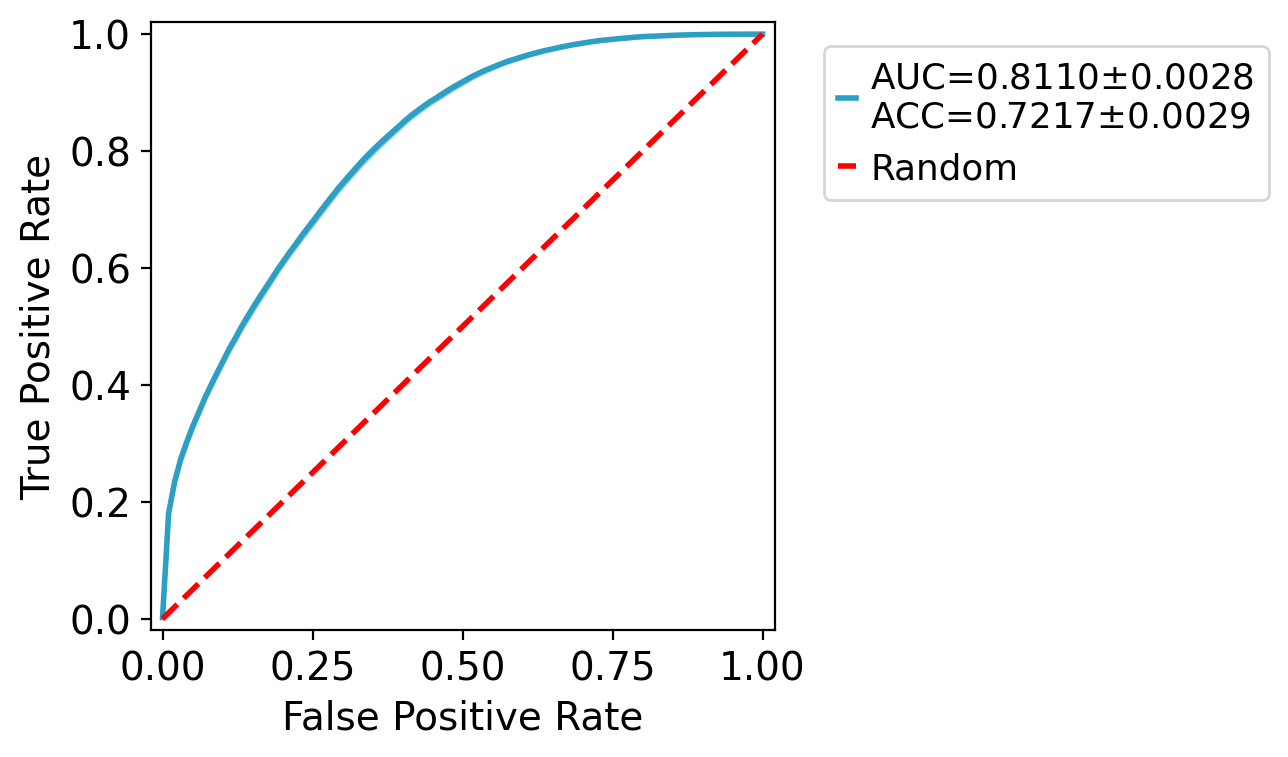

In [163]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

## retrieve model timings

In [173]:
# get a summary of the n-parameters for the model
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_101 (InputLayer)         [(None, 30, 25)]     0           []                               
                                                                                                  
 input_102 (InputLayer)         [(None, 30, 25)]     0           []                               
                                                                                                  
 conv1d_100 (Conv1D)            (None, 28, 30)       2280        ['input_101[0][0]']              
                                                                                                  
 conv1d_101 (Conv1D)            (None, 28, 30)       2280        ['input_102[0][0]']              
                                                                                           

In [157]:
import time

# now read in the keras model
model = keras.models.load_model('../outputs/model_v6/model_v6.r1.keras')

# read in the validation data
hit_val = pd.read_csv('../outputs/model_v6/validation.pos.csv', index_col=0)
irr_val = pd.read_csv('../outputs/model_v6/validation.neg.csv', index_col=0)
X_cdr3as_val, X_cdr3bs_val, X_ags_val, y_val = convert_to_X(hit_val, irr_val)

# set seed for random subsets
np.random.seed(0)

# retrieve values and aucs
timings = pd.DataFrame(columns=['n_rows','total_time'])

# test for timings, we test 2000 increments but 5 rounds each to get good standard errors
n_rounds = 10
step_size = 2000
for round_num in range(1, n_rounds+1):
    for _ in range(5):
        # grab the random idxs
        idxs = np.random.choice(y_val.index, size=step_size*(round_num+1), replace=False)

        # testing predictions
        start_time = time.time()
        y_pred = model.predict([X_cdr3as_val[idxs], X_cdr3bs_val[idxs], X_ags_val[idxs]],
                               workers=1, use_multiprocessing=False)[:, 0]
        end_time = time.time()
        total_time = end_time - start_time

        # save data
        timings.loc[timings.shape[0]] = step_size*(round_num+1), total_time

688/688 [==============================] - 2s 4ms/step


/tmp/ipykernel_8236/2374033471.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='n_rows', y='total_time', data=timings, color='#56D8F8', edgecolor='#2D9FC4', linewidth=2,
/tmp/ipykernel_8236/2374033471.py:5: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x='n_rows', y='total_time', data=timings, color='#56D8F8', edgecolor='#2D9FC4', linewidth=2,
/tmp/ipykernel_8236/2374033471.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(x='n_rows', y='total_time', data=timings, color='#56D8F8', edgecolor='#2D9FC4', linewidth=2,


(0.0, 3.307064309120178)

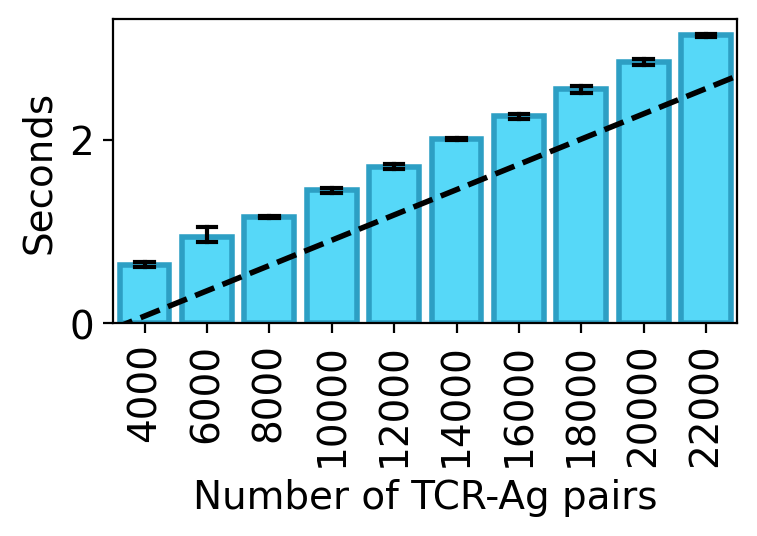

In [158]:
# plot the timings
fig, ax = plt.subplots(figsize=[4, 2])
ax.grid(False)
timings['n_rows'] = timings['n_rows'].astype(int)
sns.barplot(x='n_rows', y='total_time', data=timings, color='#56D8F8', edgecolor='#2D9FC4', linewidth=2,
            errcolor='k', ci=95, errwidth=1.5, capsize=0.3, saturation=1)
ax.tick_params(axis='x', labelrotation=90)
ax.set(xlabel='Number of TCR-Ag pairs', ylabel='Seconds')
# solve for the equation
xlim, ylim = ax.get_xlim(), ax.get_ylim()
trend = np.polynomial.Polynomial(0).fit(timings['n_rows']/step_size, timings['total_time'], 1)
xs, ys = trend.linspace(domain=xlim)
ax.plot(xs, ys, linestyle='--', color='k', linewidth=2)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

In [159]:
# solve for the equation
fit = np.polynomial.Polynomial(0).fit(timings['total_time'], timings['n_rows'], 1)
fit

Polynomial([13116.37021556,  9235.16663659], domain=[0.60898733, 3.15949917], window=[-1.,  1.])

In [160]:
# calculate slope
fit.convert().coef[1]

7241.814370432909

## perform external comparisons of tarpon a/b with state-of-art

In [88]:
# read in validation data
hit_val = pd.read_csv('../outputs/model_v6/validation.pos.csv', index_col=0)
irr_val = pd.read_csv('../outputs/model_v6/validation.neg.csv', index_col=0)
X_cdr3as_val, X_cdr3bs_val, X_ags_val, y_val = convert_to_X(hit_val, irr_val)

In [89]:
# select for epitopes that are test-able
!mkdir ../outputs/model_comparison_v2
for epitope in ['GILGFVFTL','NLVPMVATV','GLCTLVAML']:
    # append the original dataframes together for further testing
    df_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
    # subset on the relevant peptide
    y = y_val.loc[df_val['Epitope'] == epitope]
    df_val = df_val.loc[df_val['Epitope'] == epitope]
    # write the files down
    df_val.to_csv(f'../outputs/model_comparison_v2/val.{epitope}.csv')
    y.to_csv(f'../outputs/model_comparison_v2/val.{epitope}.y.csv')

# loop through the filenames to create appropriate inputs
for epitope in ['GILGFVFTL','NLVPMVATV','GLCTLVAML']:
    # read in input dataframes
    X = pd.read_csv(f'../outputs/model_comparison_v2/val.{epitope}.csv', index_col=0)
    y = pd.read_csv(f'../outputs/model_comparison_v2/val.{epitope}.y.csv', index_col=0)

    # write for NetTCR2 (CLI version)
    fn = f'../outputs/model_comparison_v2/val.{epitope}.NetTCR2_CLI.csv'
    tmp = X.copy()
    tmp.columns = ['CDR3a','CDR3b','peptide']
    tmp[['CDR3a','CDR3b','peptide']].to_csv(fn, index=False)

    # write for ERGO-II
    fn = f'../outputs/model_comparison_v2/val.{epitope}.ERGOII.csv'
    tmp = X.copy()
    tmp.columns = ['TRA','TRB','Peptide']
    tmp['MHC'] = 'HLA-A*02'
    tmp['T-Cell-Type'] = 'CD8'
    tmp = tmp.T.reindex(['TRA','TRB','TRAV','TRAJ','TRBV','TRBJ','T-Cell-Type','Peptide','MHC']).T
    tmp.to_csv(fn, index=False)

mkdir: cannot create directory ‘../outputs/model_comparison_v2’: File exists


In [90]:
# > code for ERGOII (in ergoii)
# python Predictv2.py mcpas /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GILGFVFTL.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GILGFVFTL.ERGOII.results.csv
# python Predictv2.py vdjdb /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GILGFVFTL.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GILGFVFTL.ERGOII.results_vdjdb.csv
# python Predictv2.py mcpas /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.NLVPMVATV.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.NLVPMVATV.ERGOII.results.csv
# python Predictv2.py vdjdb /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.NLVPMVATV.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.NLVPMVATV.ERGOII.results_vdjdb.csv
# python Predictv2.py mcpas /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GLCTLVAML.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GLCTLVAML.ERGOII.results.csv
# python Predictv2.py vdjdb /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GLCTLVAML.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GLCTLVAML.ERGOII.results_vdjdb.csv

# > code for NetTCR (in base_py37)
# python nettcr.py -tr test/sample_train.csv -c ab \
# -te /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GILGFVFTL.NetTCR2_CLI.csv \
# -o /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GILGFVFTL.NetTCR2.results.csv
# python nettcr.py -tr test/sample_train.csv -c ab \
# -te /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.NLVPMVATV.NetTCR2_CLI.csv \
# -o /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.NLVPMVATV.NetTCR2.results.csv
# python nettcr.py -tr test/sample_train.csv -c ab \
# -te /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GLCTLVAML.NetTCR2_CLI.csv \
# -o /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison_v2/val.GLCTLVAML.NetTCR2.results.csv

In [104]:
# define new model name
def evaluation(epitope, model_fn):
    # append the original dataframes together for further testing
    hit_tmp = hit_val.loc[hit_val['Epitope'] == epitope]
    irr_tmp = irr_val.loc[irr_val['Epitope'] == epitope]
    X_cdr3as_val, X_cdr3bs_val, X_ags_val, y_val = convert_to_X(hit_tmp, irr_tmp)
    
    # create tracking variable
    models = ['TARPON','NetTCR2','ERGOII-McPAS','ERGOII-VDJdb','AVIB']
    df_metrics = pd.DataFrame(index=['AUC','ACC'], columns=models)

    # load in the model
    model = keras.models.load_model(model_fn)

    # > our model
    # testing predictions
    y_pred = model.predict([X_cdr3as_val, X_cdr3bs_val, X_ags_val], workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr_modelv5, tpr_modelv5, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('Model v5')
    print('AUC', auc(fpr_modelv5, tpr_modelv5))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['TARPON'] = auc(fpr_modelv5, tpr_modelv5), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # > Net-TCR-2.0
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison_v2/val.{epitope}.NetTCR2.results.csv')
    y_pred = y_pred['prediction'].values
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr_nettcr2, tpr_nettcr2, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('Net-TCR-2.0')
    print('AUC', auc(fpr_nettcr2, tpr_nettcr2))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['NetTCR2'] = auc(fpr_nettcr2, tpr_nettcr2), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # > now read in predictions from ERGO-II (LSTM model, used HLA and CDR3b and Peptide)
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison_v2/val.{epitope}.ERGOII.results.csv')
    y_pred = y_pred['Score'].values
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr_ergoii, tpr_ergoii, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ERGO-II McPAS')
    print('AUC', auc(fpr_ergoii, tpr_ergoii))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['ERGOII-McPAS'] = auc(fpr_ergoii, tpr_ergoii), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # > now read in predictions from ERGO-II
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison_v2/val.{epitope}.ERGOII.results_vdjdb.csv')
    y_pred = y_pred['Score'].values
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr_ergoii_vdjdb, tpr_ergoii_vdjdb, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ERGO-II VDJdb')
    print('AUC', auc(fpr_ergoii_vdjdb, tpr_ergoii_vdjdb))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['ERGOII-VDJdb'] = auc(fpr_ergoii_vdjdb, tpr_ergoii_vdjdb), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # > now read in predictions from AVIB
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison_v2/val.{epitope}.AVIB.rep-0.csv')
    y_pred = y_pred['pred'].values
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr_avib, tpr_avib, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('AVIB')
    print('AUC', auc(fpr_avib, tpr_avib))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['AVIB'] = auc(fpr_avib, tpr_avib), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # check the AUC
    fig, ax = plt.subplots(figsize=[4, 4])
    ax.plot(fpr_modelv5, tpr_modelv5, lw=2, label='TARPON (this study)')
    ax.plot(fpr_nettcr2, tpr_nettcr2, lw=2, label='NetTCR - 2.0')
    ax.plot(fpr_ergoii, tpr_ergoii, lw=2, label='ERGO-II McPAS')
    ax.plot(fpr_ergoii_vdjdb, tpr_ergoii_vdjdb, lw=2, label='ERGO-II VDJdb')
    plt.plot(fpr_avib, tpr_avib, lw=2, label='AVIB')
    ax.plot([0, 1], [0, 1], color='r', linestyle='--')
    ax.grid(False)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(f'{epitope} on Validation Data')
    ax.legend(frameon=False, bbox_to_anchor=(1.01, 1.01),
              loc='upper left', bbox_transform=ax.transAxes)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    
    return df_metrics

In [105]:
# define model
model_fn = '../outputs/model_v6/model_v6.r1.keras'

14/14 [==============================] - 0s 3ms/step
Model v5
AUC 0.9356524873828407
ACC 0.8478747203579419

Net-TCR-2.0
AUC 0.8533805976127533
ACC 0.7874720357941835

ERGO-II McPAS
AUC 0.8441079868621325
ACC 0.7494407158836689

ERGO-II VDJdb
AUC 0.8194544580629657
ACC 0.4899328859060403

AVIB
AUC 0.9303252423295683
ACC 0.8635346756152126



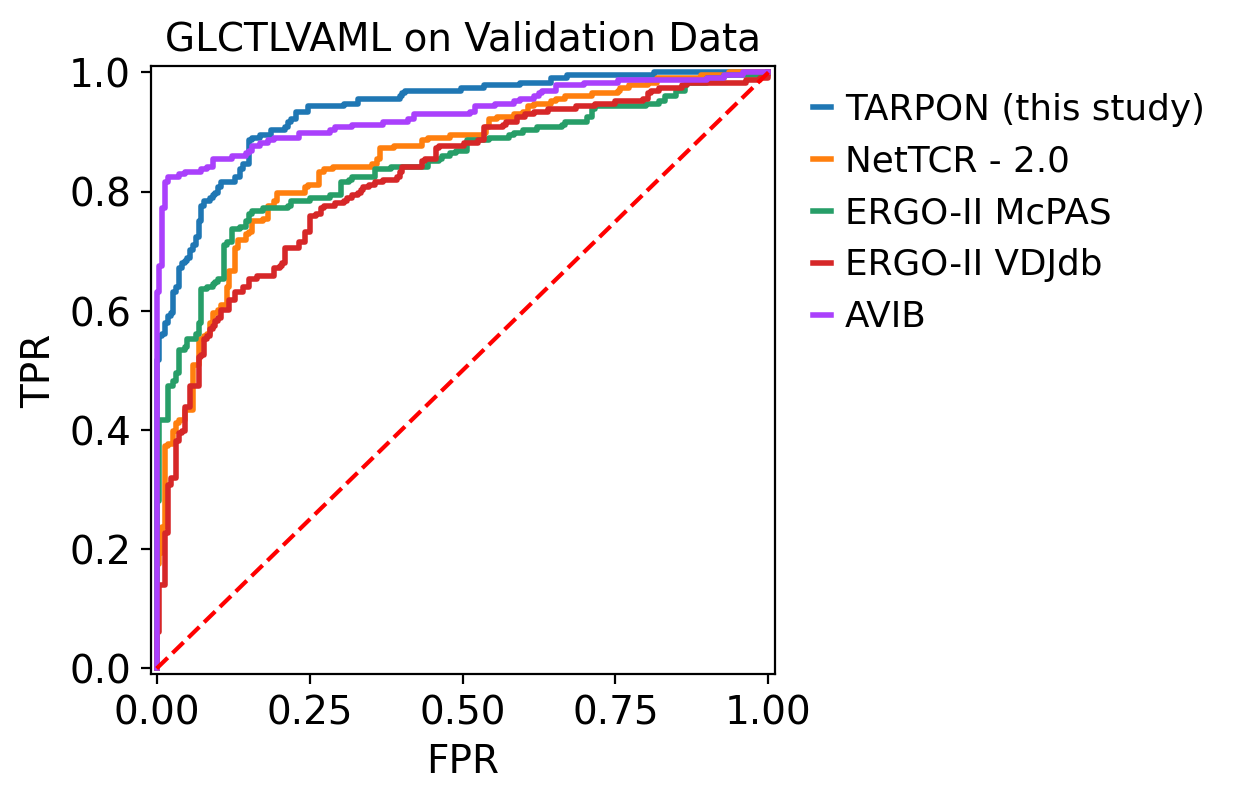

In [106]:
# predict ebv
metrics_glc = evaluation('GLCTLVAML', model_fn)

62/62 [==============================] - 0s 3ms/step
Model v5
AUC 0.9122499915989235
ACC 0.8562058526740666

Net-TCR-2.0
AUC 0.8971759144699125
ACC 0.8133198789101918

ERGO-II McPAS
AUC 0.7771260578992014
ACC 0.7204843592330978

ERGO-II VDJdb
AUC 0.9112561187840942
ACC 0.5040363269424823

AVIB
AUC 0.9583601913205168
ACC 0.9369323915237134



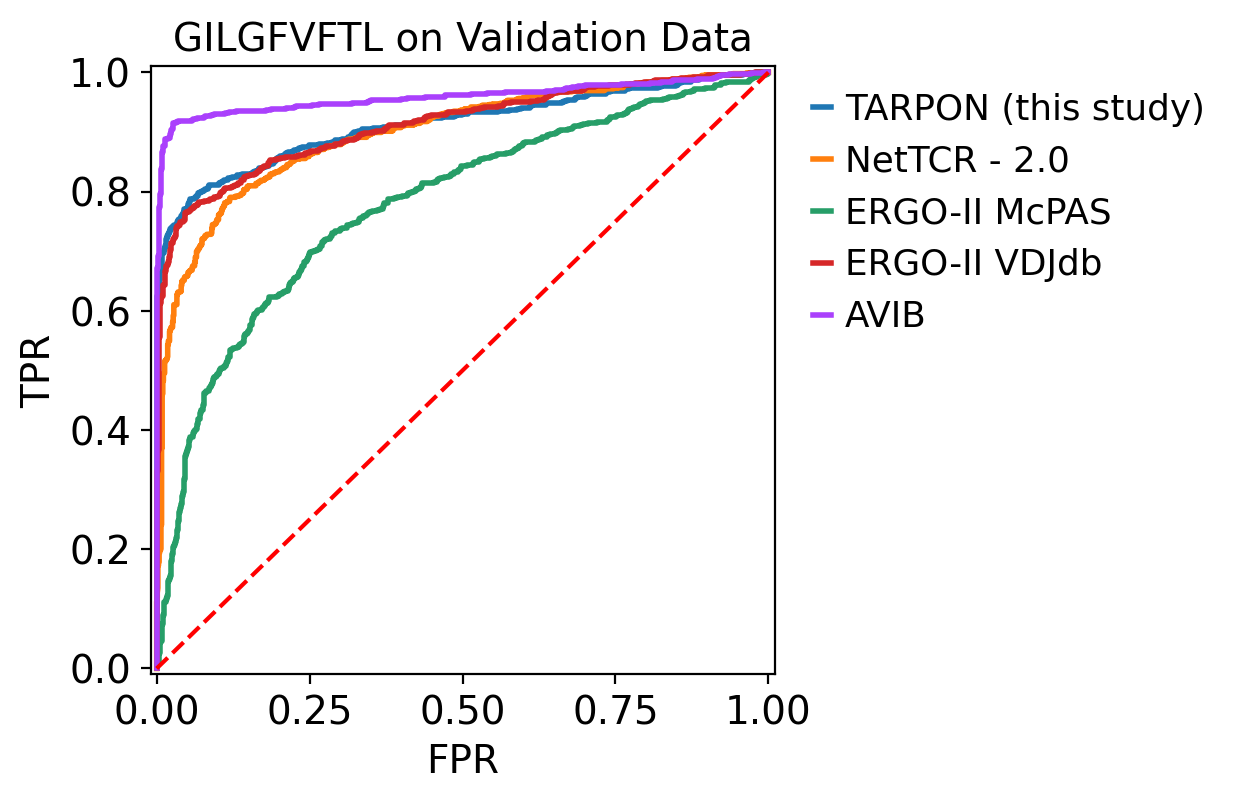

In [107]:
# predict iav
metrics_gil = evaluation('GILGFVFTL', model_fn)

23/23 [==============================] - 0s 3ms/step
Model v5
AUC 0.7518631436314362
ACC 0.6837725381414702

Net-TCR-2.0
AUC 0.6974239344666173
ACC 0.59500693481276

ERGO-II McPAS
AUC 0.592210211874846
ACC 0.5839112343966713

ERGO-II VDJdb
AUC 0.5800458856861296
ACC 0.5117891816920943

AVIB
AUC 0.7409383468834689
ACC 0.7087378640776699



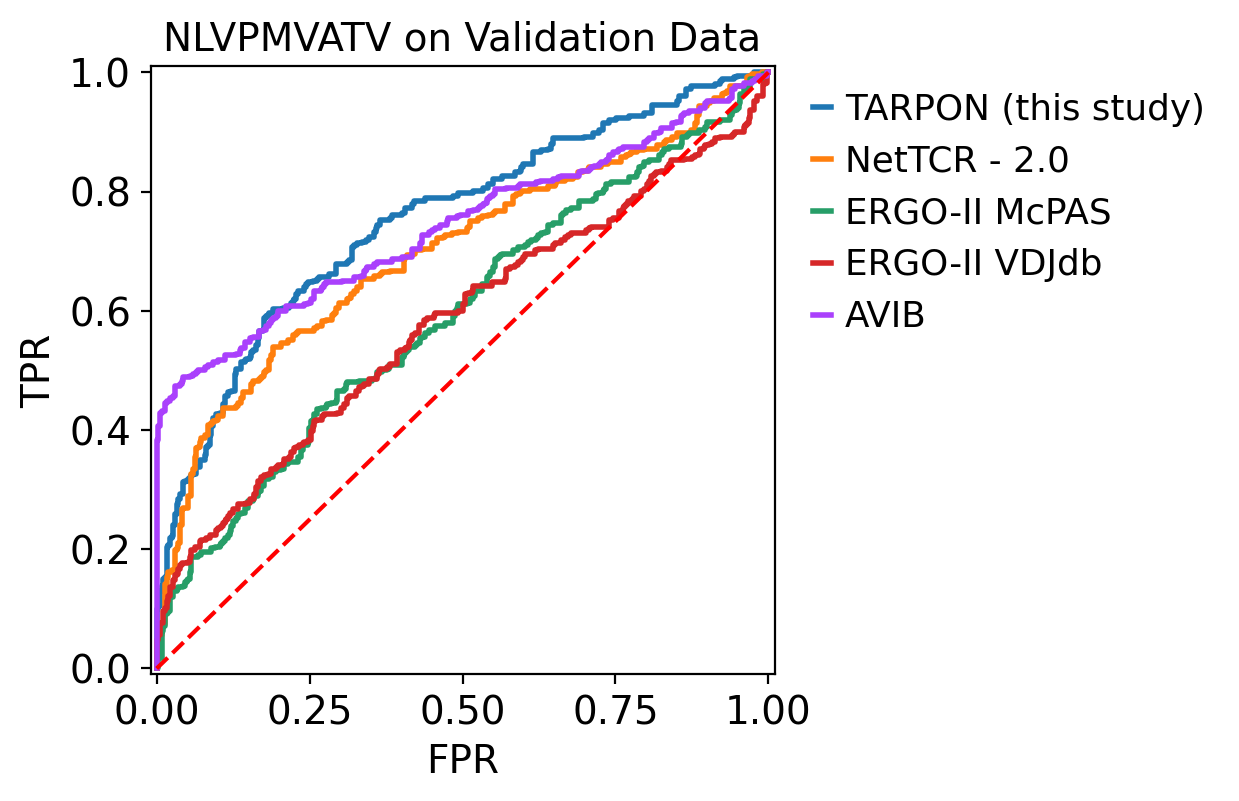

In [108]:
# predict cmv
metrics_nlv = evaluation('NLVPMVATV', model_fn)

In [169]:
# add the antigen names
metrics_gil.index = 'GIL-' + metrics_gil.index
metrics_nlv.index = 'NLV-' + metrics_nlv.index
metrics_glc.index = 'GLC-' + metrics_glc.index
# combine the dataframe together
metrics = pd.concat([metrics_gil, metrics_nlv, metrics_glc], axis=0).T
# define acc columns and auc columns
cols_auc = metrics.columns[metrics.columns.str.endswith('-AUC')]
cols_acc = metrics.columns[metrics.columns.str.endswith('-ACC')]

In [184]:
# set order
order = ['TARPON','AVIB','NetTCR2','ERGOII-McPAS','ERGOII-VDJdb']

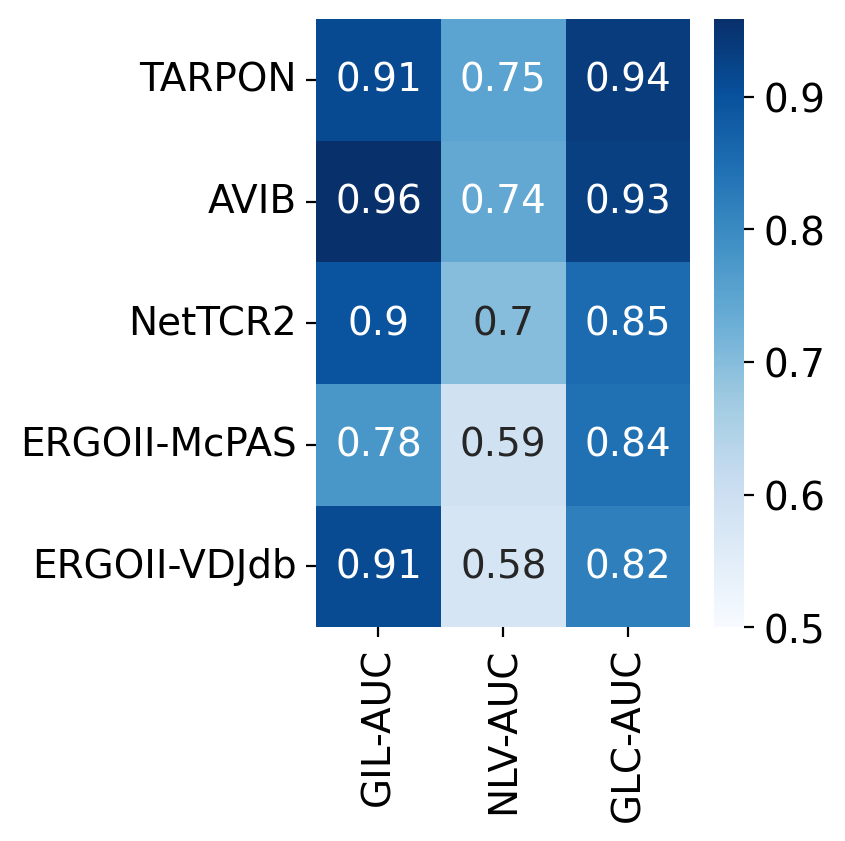

In [185]:
# create heatmap for auc
fig, ax = plt.subplots(figsize=[3, 4])
g = sns.heatmap(metrics.loc[order, cols_auc], annot=True, cmap='Blues', ax=ax, vmin=0.5)

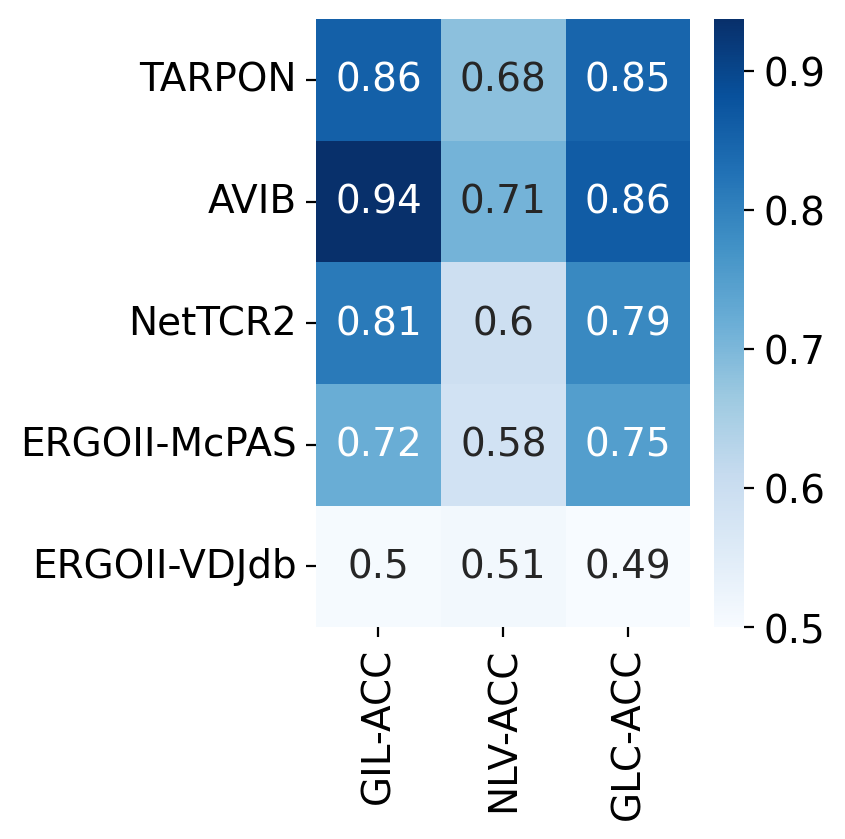

In [186]:
# create heatmap for acc
fig, ax = plt.subplots(figsize=[3, 4])
g = sns.heatmap(metrics.loc[order, cols_acc], annot=True, cmap='Blues', ax=ax, vmin=0.5)